In [330]:
import pandas as pd

# 1、数据预处理
df = pd.read_csv("/Users/datou/PycharmProjects/model/JianyangSta/JY_data/建阳站日降雨径流蒸发资料(完整）.csv", parse_dates=["Date"])
df_copy = df
df.reset_index(drop=True)
df = df.set_index('Date')
df

,Q,P
Date,,
2000-03-04,95.218583,2.779
2000-03-05,111.431333,2.721
2000-03-06,92.994458,1.991
2000-03-07,90.252708,5.497
2000-03-08,86.227667,4.970
...,...,...
2018-10-26,39.116250,8.492
2018-10-27,46.711250,5.857
2018-10-28,70.970417,3.264


In [331]:
n_past=15

In [332]:
"""
划分数据
"""
test_split = round(len(df) * 0.30)
df_for_training = df[:-test_split]
df_for_testing = df[-(test_split+n_past):]
df_for_training

,Q,P
Date,,
2000-03-04,95.218583,2.779
2000-03-05,111.431333,2.721
2000-03-06,92.994458,1.991
2000-03-07,90.252708,5.497
2000-03-08,86.227667,4.970
...,...,...
2013-03-22,179.575000,0.000
2013-03-23,254.883333,8.498
2013-03-24,518.239583,30.304


In [333]:
from sklearn.preprocessing import StandardScaler
import numpy as np

"""
数据归一化
"""
scaler = StandardScaler().fit(df_for_training)
df_for_training = scaler.transform(df_for_training)
df_for_testing = scaler.transform(df_for_testing)


In [334]:
timesteps = 16
train_data = np.array(
    [[j for j in df_for_training[i:i + timesteps]] for i in range(0, len(df_for_training) - timesteps + 1)])[:, :, 0]
train_data

array([[-0.30719018, -0.24484738, -0.31574259, ...,  0.11019313,
        -0.09017843, -0.1094363 ],
       [-0.24484738, -0.31574259, -0.32628543, ..., -0.09017843,
        -0.1094363 , -0.18776703],
       [-0.31574259, -0.32628543, -0.3417629 , ..., -0.1094363 ,
        -0.18776703, -0.22359781],
       ...,
       [-0.30926279, -0.37844925, -0.37465042, ...,  0.01718508,
         0.30676779,  1.3194501 ],
       [-0.37844925, -0.37465042, -0.36970601, ...,  0.30676779,
         1.3194501 ,  0.64534596],
       [-0.37465042, -0.36970601, -0.37501733, ...,  1.3194501 ,
         0.64534596,  0.72576068]])

In [335]:
# 单变量嵌套表格
test_data=np.array([[j for j in df_for_testing[i:i+timesteps]] for i in range(0,len(df_for_testing)-timesteps+1)])[:,:,0]
test_data.shape

(2044, 16)

In [336]:
trainX, trainY = train_data[:,:timesteps-1],train_data[:,[timesteps-1]]
testX, testY = test_data[:,:timesteps-1],test_data[:,[timesteps-1]]
trainX.shape

(4756, 15)

In [337]:
testY.shape

(2044, 1)

In [338]:
# 创建数据集，n_past：时间步长
# def createXY(dataset, n_past):
#     dataX = []
#     dataY = []
#     for i in range(n_past, len(dataset)):
#         dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
#         dataY.append(dataset[i, 0])
#     return np.array(dataX), np.array(dataY)


In [339]:
# trainX, trainY = createXY(df_for_training, 30)
# trainX.shape, trainY.shape

In [340]:
# testX, testY = createXY(df_for_testing, 30)
# testX.shape, testY.shape

In [341]:
"""
构建SVR回归模型
"""
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# 构建模型
# 使用网格搜索寻找最优参数
param_grid = {"kernel": ["rbf"], 'C':[1,10,50], 'gamma': [0.001,0.01,0.1,1]}
grid_svr = GridSearchCV(SVR(), param_grid, cv=5)
grid_svr.fit(trainX, trainY)
my_model = grid_svr.best_estimator_
# 预测
my_model.fit(trainX, trainY)
y_pred = my_model.predict(testX)
y_pred

/Users/datou/anaconda3/envs/normal310/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/datou/anaconda3/envs/normal310/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/datou/anaconda3/envs/normal310/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/datou/anaconda3/envs/normal310/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A colu

array([ 0.4222602 ,  0.39640515,  0.18604898, ..., -0.43465596,
       -0.3775452 , -0.39951994])

In [342]:
grid_svr.best_params_

{'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}

In [343]:
"""
进行预测：训练集
"""
train_predict=my_model.predict(trainX)

In [344]:
# 对数据进行逆缩放
y_pred_copy = np.repeat(y_pred, 2, axis=-1)
pred = scaler.inverse_transform(np.reshape(y_pred_copy, (len(y_pred), 2)))[:, 0]
pred = pd.DataFrame(pred)
pred.columns = ["Qsim"]
pred

,Qsim
0,284.918071
1,278.194257
2,223.489427
3,249.696727
4,237.463596
...,...
2039,57.608649
2040,57.429708
2041,62.070074
2042,76.922191


In [345]:
# 同样步骤进行逆变换
original_copies_array = np.repeat(testY, 2, axis=-1)
original = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), 2)))[:, 0]
original.shape

(2044,)

In [346]:
# 对测试集输出数据进行逆变换
prediction_copies_array = np.repeat(train_predict, 2, axis=-1)
train_pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(train_predict), 2)))[:, 0]
train_pred.shape

(4756,)

In [347]:
# 对测试数据Y进行逆变换
train_original_copies_array = np.repeat(trainY, 2, axis=-1)
train_original = scaler.inverse_transform(np.reshape(train_original_copies_array, (len(trainY), 2)))[:, 0]
train_original.shape

(4756,)

In [348]:
train_pred=pd.DataFrame(train_pred)
train_pred.columns=['Qsim']
train_pred

,Qsim
0,150.465695
1,151.061942
2,131.982057
3,124.157396
4,120.291552
...,...
4751,204.622804
4752,149.277046
4753,210.729065
4754,378.453724


In [349]:
original=pd.DataFrame(original)
original.columns=['Qobs']
original

,Qobs
0,357.285417
1,266.375000
2,292.975000
3,279.295833
4,263.750000
...,...
2039,39.116250
2040,46.711250
2041,70.970417
2042,64.495417


In [350]:
train_original=pd.DataFrame(train_original)
train_original.columns=['Qobs']
train_original

,Qobs
0,146.646083
1,126.275542
2,116.957458
3,107.373583
4,157.025792
...,...
4751,179.575000
4752,254.883333
4753,518.239583
4754,342.933333


In [351]:
test_df=df_copy[-test_split:]
test_df

,Date,Q,P
4771,2013-03-27,357.285417,0.000
4772,2013-03-28,266.375000,5.566
4773,2013-03-29,292.975000,15.177
4774,2013-03-30,279.295833,7.662
4775,2013-03-31,263.750000,0.622
...,...,...,...
6810,2018-10-26,39.116250,8.492
6811,2018-10-27,46.711250,5.857
6812,2018-10-28,70.970417,3.264
6813,2018-10-29,64.495417,0.000


In [352]:
train_df=df_copy[n_past:-test_split]
train_df

,Date,Q,P
15,2000-03-19,146.646083,0.000
16,2000-03-20,126.275542,1.392
17,2000-03-21,116.957458,0.456
18,2000-03-22,107.373583,12.329
19,2000-03-23,157.025792,3.150
...,...,...,...
4766,2013-03-22,179.575000,0.000
4767,2013-03-23,254.883333,8.498
4768,2013-03-24,518.239583,30.304
4769,2013-03-25,342.933333,0.000


In [353]:
test_df=test_df.reset_index(drop=True)
test_df=test_df['Date']
test_df

0      2013-03-27
1      2013-03-28
2      2013-03-29
3      2013-03-30
4      2013-03-31
          ...    
2039   2018-10-26
2040   2018-10-27
2041   2018-10-28
2042   2018-10-29
2043   2018-10-30
Name: Date, Length: 2044, dtype: datetime64[ns]

In [354]:
train_df=train_df.reset_index(drop=True)
train_df=train_df['Date']
train_df

0      2000-03-19
1      2000-03-20
2      2000-03-21
3      2000-03-22
4      2000-03-23
          ...    
4751   2013-03-22
4752   2013-03-23
4753   2013-03-24
4754   2013-03-25
4755   2013-03-26
Name: Date, Length: 4756, dtype: datetime64[ns]

In [355]:
test_df_full=pd.concat([test_df,original,pred],axis=1)
test_df_full=test_df_full.reset_index(drop=True)
test_df_full=test_df_full.set_index('Date')
test_df_full.to_csv('/Users/datou/PycharmProjects/model/JianyangSta/JY_data/JY_TestSVR.csv')
test_df_full

,Qobs,Qsim
Date,,
2013-03-27,357.285417,284.918071
2013-03-28,266.375000,278.194257
2013-03-29,292.975000,223.489427
2013-03-30,279.295833,249.696727
2013-03-31,263.750000,237.463596
...,...,...
2018-10-26,39.116250,57.608649
2018-10-27,46.711250,57.429708
2018-10-28,70.970417,62.070074


In [356]:
train_df_full=pd.concat([train_df,train_original,train_pred],axis=1)
train_df_full=train_df_full.reset_index(drop=True)
train_df_full=train_df_full.set_index('Date')
train_df_full.to_csv('/Users/datou/PycharmProjects/model/JianyangSta/JY_data/JY_TrainSVR.csv')
train_df_full

,Qobs,Qsim
Date,,
2000-03-19,146.646083,150.465695
2000-03-20,126.275542,151.061942
2000-03-21,116.957458,131.982057
2000-03-22,107.373583,124.157396
2000-03-23,157.025792,120.291552
...,...,...
2013-03-22,179.575000,204.622804
2013-03-23,254.883333,149.277046
2013-03-24,518.239583,210.729065


In [357]:
from tool import Indicator

Indicator.eval(test_df_full['Qsim'], test_df_full['Qobs'])

MAE:60.47586272976033
RMSE:176.52831618893237
R2:0.6121750958859713
NSE:0.6121750958859726
RE:-13.055362897238082
Qmaxe:0.39503915415713525
Qmine:0.8342889293818198


(60.47586272976033,
 176.52831618893237,
 0.6121750958859713,
 0.6121750958859726,
 -13.055362897238082,
 0.39503915415713525,
 0.8342889293818198)

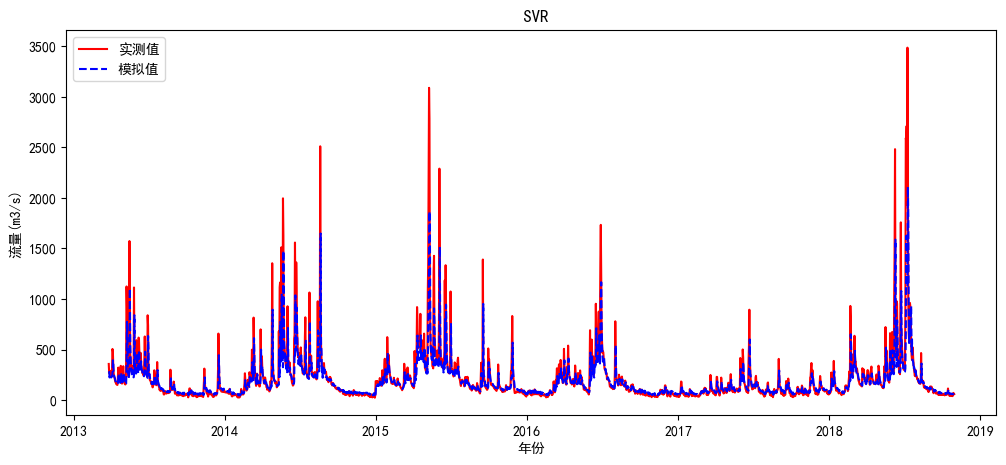

In [358]:
# 比较预测值和原始值，进行绘图展示
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(test_df_full['Qobs'], color='red', label='实测值')
plt.plot(test_df_full['Qsim'], color='blue', label='模拟值',linestyle="--")
plt.title(' SVR' )
plt.xlabel('年份')
plt.ylabel('流量(m3/s)')
plt.legend()
plt.savefig("/Users/datou/PycharmProjects/model/JianyangSta/JY_picture/TestSVR.png")
plt.show()

MAE:51.18219420306278
RMSE:167.50868821982039
R2:0.5862757308597073
NSE:0.586275730859708
RE:-10.58868488989282
Qmaxe:0.5252043669819411
Qmine:2.1327856047753007


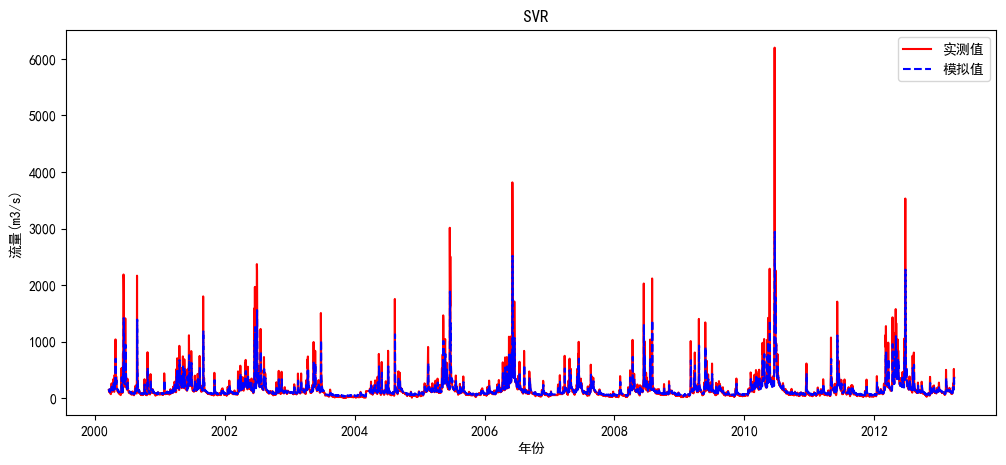

In [359]:
# 计算nash效率系数
train_mae,train_rmse,train_r2,train_nse,train_re,train_qmaxe,train_qmine = Indicator.eval(train_df_full['Qsim'], train_df_full['Qobs'])
# 比较预测值和原始值，进行绘图展示
plt.figure(figsize=(12,5))
plt.plot(train_df_full['Qobs'], color='red', label='实测值')
plt.plot(train_df_full['Qsim'], color='blue', label='模拟值',linestyle="--")
plt.title(' SVR' )
plt.xlabel('年份')
plt.ylabel('流量(m3/s)')
plt.legend()
plt.savefig("/Users/datou/PycharmProjects/model/JianyangSta/JY_picture/TrainSVR.png")
plt.show()